# COMP90051 Workshop 5
## Pytorch Fundamentals + Multiclass Logistic Regression 

[Pytorch](https://pytorch.org/) is a open-source Python library designed for fast matrix computations on CPU/GPU. This includes both standard linear algebra and deep learning-specific operations. It is based on the neural network backend of the [Torch library](http://torch.ch/). A central feature of Pytorch is its use of Automatic on-the-fly differentiation ([Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) to compute derivatives of (almost) all computations involving tensors, so we can make use of gradient-based updates to optimize some objective function. In this workshop we will introduce some fundamental operations in Pytorch and implement the multiclass logistic regression classifiers in Pytorch.

## 1. Basic Ops

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
import time, os

import torch
from torch.utils import data
import numpy as np

We will not spend much time covering basic operations here. The basic API is extremely similar to `numpy`. One may consult the [excellent introduction at the official Pytorch repository](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). 

* The fundamental object in Pytorch is the Tensor. This is a generalized matrix - essentially an $n$-dimensional table of numerical values. 

In [2]:
x = torch.Tensor([2,7,1,8,2])
print(x**2)

tensor([ 4., 49.,  1., 64.,  4.])


* One may perform the basic mathematical operations expected on Tensors. 3D tensors can be used to represent a sequence of identically sized 2D matrices - or a multichannel image.

In [ ]:
x = torch.randn(size=[3,3,3])
for i in range(x.shape[0]):
    print(x[i,:,:])

* Similarly, 4D tensors can be used to represent a sequence of 3D tensors, or a matrix of identically sized matrices.

In [3]:
x = torch.randn(size=[2,2,2,2])

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        print(x[i,j,:,:])

tensor([[ 0.7889, -0.0484],
        [-0.6098, -0.2748]])
tensor([[-2.1087,  0.1260],
        [-0.4845,  0.5737]])
tensor([[ 0.8588, -0.1892],
        [-0.8118,  0.6189]])
tensor([[-0.7270,  1.5670],
        [ 0.3078,  0.5329]])


* We can easily convert between `numpy` arrays and `torch` tensors.

In [4]:
x = np.ones(9)*2
x_pt = torch.from_numpy(x)
print(x)
print(x_pt)

[2. 2. 2. 2. 2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=torch.float64)


In [5]:
x_pt = torch.pow(x_pt,8)
# Create a new 'view' of the same underlying 1D vector of 
# numbers stored in memory - similar to np.reshape
x_pt = x_pt.view([3,3])  
x = x_pt.numpy()
print(x)

[[256. 256. 256.]
 [256. 256. 256.]
 [256. 256. 256.]]


## 2. Autograd
To compute the gradients of tensors with respect to other tensors, a full record of operations performed on the Tensor must be retained. This can be achieved by setting the attribute `.requires_grad = True`. After the computation is finished, calling `.backward()` on the output tensor walks through the computation history in reverse order to automatically compute the gradients using a method based on the chain rule, which can be used for optimization of arbitrary loss functions.

In [6]:
mu = 0
x = torch.ones([3,3], requires_grad=True)
loss = torch.exp(-(x-mu)**2/(2)).mean()
loss.backward()

The gradient for the tensor `x` is accumulated into the `.grad` attribute. We would use this in some gradient based update rule.

In [7]:
x.grad

tensor([[-0.0674, -0.0674, -0.0674],
        [-0.0674, -0.0674, -0.0674],
        [-0.0674, -0.0674, -0.0674]])

Did we get the gradients right? Using the chain rule to calculate the gradients of the loss $l$ with respect to $x$ analytically, we find:

$$ l = \frac{1}{9} \exp\left[-\frac{(x-\mu)^2}{2}\right] \implies \frac{dl}{dx} = - \frac{1}{9}(x-\mu)\exp\left[-\frac{(x-\mu)^2}{2}\right] \$$

In [8]:
dl_dx = lambda x: - 1/9 * (x-mu) * np.exp(-(x-mu)**2/2)
print(dl_dx(1))

-0.06739229552362594


Ok, so the analytic gradient and the autograd-computed gradient agree - but autograd can be very useful when evaluating the derivatives of loss functions constructed as a sequence of nested operations (an example is the cross-entropy loss when using a neural network for classification) where the analytic derivative is difficult to compute symbolically.

Note that autograd is **not** symbolic or numerical (finite-differences) differentiation, both of which have trouble handling gradients of relatively long nested functions. It is essentially a dynamic-programming approach to symbolic differentiation.

## 3. MNIST

In this workshop we will look at methods developed to handle simple computer vision tasks in Pytorch. We'll start by using some convenience functions provided by Torch to download the canonical `MNIST` dataset, transform and load it into Tensor format. MNIST is a multi-class classification data set where the instances $\mathbf{x}$ are images of handwritten digits (28×28 pixels with a single 8-bit channel). Here the target $y_k \in \{0, 1, \ldots, 9\}$. We'll train in batches of multiple elements to exploit vectorization of matrix operations. 

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

In [9]:
import torchvision
import torchvision.transforms as transforms

batch_size = 64

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 14469592.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20671620.11it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 16184376.07it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4301316.05it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We can visualize 8 randomly sampled digits below. 

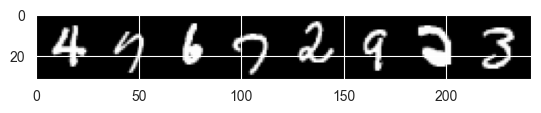

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:8]
labels = labels[:8]

imshow(torchvision.utils.make_grid(images))

## 4. Multiclass Logistic Regression

The handwritten digit recognition task is an example of a _multi-class_ classification problem. 
There are 10 classes—one for each digit $0, 1,\ldots, 9$.
We'll first tackle the problem by generalising binary logistic regression (from workshop 4), to handle _multiple classes_.

We would like to output an $m$-dimensional vector of conditional class probabilities $(p_1, p_2, \ldots, p_m)$. We require $p_k \in [0,1]$ and $\sum_k p_k=1$ by the law of total probability. Taking inspiration from the logistic regression case, we can achieve this by exponentiating the output of our classifier $f(\mathbf{x}) = W^T \mathbf{\Phi}(\mathbf{x}) = \left[\mathbf{w}_0^T\mathbf{\Phi} \vert \ldots \vert \mathbf{w}_m^T\mathbf{\Phi}\right]$, where $\mathbf{\Phi}: \mathbb{R}^d \rightarrow \mathbb{R}^D$ is some possibly nonlinear transformation typically mapping the instance $\mathbf{x} \in \mathbb{R}^d$ to some higher-dimensional space, and $\mathbf{w} \in \mathbb{R}^D$, $W \in \mathbb{R}^{D \times m}$. In essence we have multiple weight vectors $(\mathbf{w}_1, \ldots \mathbf{w}_m)$, one corresponding to each class, and the output $\mathbf{w}_k \cdot \mathbf{\Phi}(\mathbf{x})$ 'scores' how much the classifier thinks the instance $\mathbf{x}$ belongs to class $k$. More concretely, the matrix operation looks like:

\begin{equation}
    W^T \mathbf{\Phi} = \begin{bmatrix}
      \leftarrow \mathbf{w}^{T}_{0} \rightarrow \\
      \leftarrow \mathbf{w}^{T}_{1} \rightarrow \\
      \vdots \\
      \leftarrow \mathbf{w}^{T}_{m} \rightarrow \\ 
    \end{bmatrix}
    \begin{bmatrix}
      \mathbf{\Phi}^{(1)}  \\
      \mathbf{\Phi}^{(2)}  \\
      \vdots \\
      \mathbf{\Phi}^{(D)}
    \end{bmatrix}
    = \begin{bmatrix}
      \mathbf{w}_0 \cdot \mathbf{\Phi}  \\
      \mathbf{w}_1 \cdot \mathbf{\Phi}  \\
      \vdots \\
      \mathbf{w}_m \cdot \mathbf{\Phi}
    \end{bmatrix} \in \mathbb{R}^m
\end{equation}

This will return a vector of length $m$. Each dimension of this vector should correspond to the unnormalized probability $\tilde{p}_k$, commonly referred to as the _logits_. We then require normalization of the probability output, which can be achieved by dividing by $\sum_k \tilde{p}_k$. Hence we have:
\begin{align}
    p(y=k \vert \mathbf{x}) = \frac{\exp\left[\left(\mathbf{w}_k^T \Phi(\mathbf{x})\right)\right]}{\sum_n \exp\left[\left(\mathbf{w}_n^T \Phi(\mathbf{x})\right)\right]}
\end{align}
The process of converting the unnormalized weight-feature dot product(s) to a normalized distribution is called a softmax operation. Since the exponential is monotonic, the class prediction is given by taking the index with the highest conditional probability - i.e. the highest score $\mathbf{w}_k^T \mathbf{\Phi}(\mathbf{x})$. The classifier is trained by minimizing the negative log likelihood, which corresponds to the negative cross entropy loss.

\begin{equation}
    \mathcal{L}(\mathbf{w}) = -\log \prod_k p(y=k \vert \mathbf{x}; \mathbf{w}) = -\sum_k y_k \log p\left(y=k \vert \mathbf{x}; \mathbf{w}\right)
\end{equation}

## 5. Defining the model

#### The following sections are especially important! Please ensure you understand every word below, and bother your tutor if anything is unclear!


Let's step through what we need to setup before we can invoke the training loop. The first thing on the agenda is to define our trainable parameters - in this case, the $10$ weight vectors arranged into a `[n_classes, n_features]` matrix and a bias vector of length `n_classes`. We'll use a popular empirically motivated initialization scheme called Xavier/Glorot initialization to use for our initial weight parameters. Note that here we are using each pixel in the image as a feature. This is not the ideal way to process the information contained within a natural image, but we'll stick with it for the sake of simplicity. `MNIST` is so simple that almost any sensible method will yield ~90 \%$ accuracy!

In [12]:
n_classes = 10
n_features = 784
n_epochs = 10

# W = torch.zeros([n_features, n_classes], requires_grad=True)
W = torch.nn.init.xavier_uniform_(torch.empty([n_features, n_classes], requires_grad=True))  # Initialize weight vector
b = torch.zeros([n_classes], requires_grad=True)

Remember that the logits (unnormalized probabilities) are defined as the result of the computation $\tilde{p}_k = W^T \mathbf{x} + b$, where $\mathbf{x}$ is the flattened image. This will return a vector of length `n_classes`. Each entry in this vector corresponds to an unnormalized score corresponding to the likelihood of the class index (higher is better).

In [13]:
x = images[0]  # Take a sample iamge
x = x.view(-1)  # Flatten the image
logits = torch.matmul(torch.t(W),x) + b  # Compute logits
print(logits)

tensor([-1.0543,  0.3979, -1.0198,  1.9085,  0.3908,  0.8168,  0.3664, -0.0440,
        -0.4473,  0.0684], grad_fn=<AddBackward0>)


Below we define the loss function we will use and construct an optimizer that will update the learnable parameters in our model through some gradient-based update scheme to minimize the loss function. In this case just vanilla SGD. We need to supply all the learnable parameters in our model to the `parameters` argument. This is needed for MLE, as we saw earlier.

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([W,b], lr=1e-2)

We have defined the learnable parameters, and defined a loss function and optimizer that tells us how to update our parameters to minimize the cross-entropy loss. Now we enter the training loop.

In [15]:
LOG_INTERVAL = 250
running_loss, running_accuracy = list(), list()
start_time = time.time()

for epoch in range(n_epochs):  # Loop over training dataset `n_epochs` times
    
    epoch_loss = 0.
    
    for i, data in enumerate(train_loader):  # Loop over elements in training set
        
        x, labels = data
        
        x = x.view(batch_size, -1)  # Flatten images but keep batch dimension
        logits = torch.matmul(x,W) + b  # Compute scores
        
        predictions = torch.argmax(logits, dim=1)
        train_acc = torch.mean(torch.eq(predictions, labels).float()).item()
        
        loss = criterion(input=logits, target=labels)
    
        loss.backward()               # Backward pass (compute parameter gradients)
        optimizer.step()              # Update weight parameter using SGD
        optimizer.zero_grad()         # Reset gradients to zero for next iteration
        
        
        # ============================================================================
        # You can safely ignore the boilerplate code below - just reports metrics over
        # training and test sets

        running_loss.append(loss.item())
        running_accuracy.append(train_acc)
        
        epoch_loss += loss.item()

        if i % LOG_INTERVAL == 0:  # Log training stats
            deltaT = time.time() - start_time
            mean_loss = epoch_loss / (i+1)
            print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f} | Train accuracy {:.5f} | Time {:.2f} s'.format(epoch, 
                i, len(train_loader), mean_loss, train_acc, deltaT))
        
    print('Epoch complete! Mean loss: {:.4f}'.format(epoch_loss/len(train_loader)))
    
    test_loss = 0.
    test_preds, test_labels = list(), list()
    for i, data in enumerate(test_loader):
        x, labels = data
        x = x.view(batch_size, -1)  # Flatten images but keep batch dimension
        
        with torch.no_grad():
            logits = torch.matmul(x,W) + b  # Compute scores
            predictions = torch.argmax(logits, dim=1)
            test_loss += criterion(input=logits, target=labels).item()
            test_preds.append(predictions)
            test_labels.append(labels)
            
    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_accuracy = torch.eq(test_preds, test_labels).float().mean().item()
    
    print('[TEST] Mean loss {:.4f} | Accuracy {:.4f}'.format(test_loss/len(test_loader), test_accuracy))

[TRAIN] Epoch 0 [0/937]| Mean loss 2.4927 | Train accuracy 0.04688 | Time 0.01 s
[TRAIN] Epoch 0 [250/937]| Mean loss 1.5888 | Train accuracy 0.71875 | Time 0.57 s
[TRAIN] Epoch 0 [500/937]| Mean loss 1.2680 | Train accuracy 0.82812 | Time 1.10 s
[TRAIN] Epoch 0 [750/937]| Mean loss 1.0953 | Train accuracy 0.87500 | Time 1.63 s
Epoch complete! Mean loss: 1.0100
[TEST] Mean loss 0.6100 | Accuracy 0.8603
[TRAIN] Epoch 1 [0/937]| Mean loss 0.6377 | Train accuracy 0.84375 | Time 2.33 s
[TRAIN] Epoch 1 [250/937]| Mean loss 0.6115 | Train accuracy 0.81250 | Time 2.87 s
[TRAIN] Epoch 1 [500/937]| Mean loss 0.5865 | Train accuracy 0.89062 | Time 3.41 s
[TRAIN] Epoch 1 [750/937]| Mean loss 0.5681 | Train accuracy 0.85938 | Time 3.95 s
Epoch complete! Mean loss: 0.5592
[TEST] Mean loss 0.4816 | Accuracy 0.8809
[TRAIN] Epoch 2 [0/937]| Mean loss 0.5499 | Train accuracy 0.85938 | Time 4.65 s
[TRAIN] Epoch 2 [250/937]| Mean loss 0.4944 | Train accuracy 0.82812 | Time 5.19 s
[TRAIN] Epoch 2 [500/937

You should be getting $>90/\%$ train accuracy with similar test accuracy within a minute on CPU _(note to tutors - check on your machine?)_, not bad for a _linear method_! 😎 Let's plot the loss and accuracy curves. You may want to fiddle with the learning rate when your loss stats to plateau.

In [16]:
from scipy.signal import savgol_filter  # Smooth spiky curves
running_loss_smoothed = savgol_filter(running_loss, 21, 3)
running_acc_smoothed = savgol_filter(running_accuracy, 21, 3)

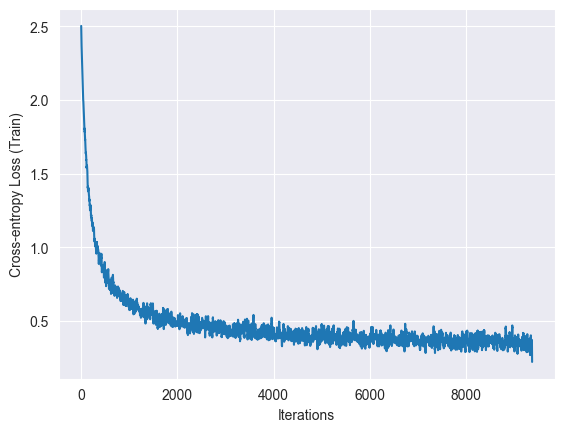

In [17]:
plt.plot(running_loss_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss (Train)')
plt.show()

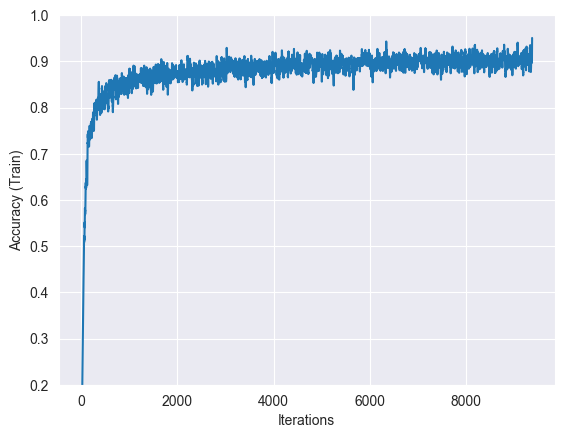

In [18]:
plt.plot(running_acc_smoothed)
plt.xlabel('Iterations')
plt.ylabel('Accuracy (Train)')
plt.ylim(0.2,1.)
plt.show()